In [325]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [326]:
df = pd.read_csv('train_basic.csv')

In [327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16784 entries, 0 to 16783
Data columns (total 48 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         16784 non-null  int64  
 1   listing_id         16784 non-null  int64  
 2   title              16784 non-null  object 
 3   make               16784 non-null  object 
 4   model              16784 non-null  object 
 5   description        16439 non-null  object 
 6   manufactured       16590 non-null  float64
 7   original_reg_date  318 non-null    object 
 8   reg_date           16583 non-null  object 
 9   type_of_vehicle    16784 non-null  object 
 10  category           16784 non-null  object 
 11  transmission       16784 non-null  object 
 12  curb_weight        16205 non-null  float64
 13  power              16784 non-null  float64
 14  fuel_type          3490 non-null   object 
 15  engine_cap         16784 non-null  float64
 16  no_of_owners       166

In [328]:
df["remaining_coe"] = df["remaining_coe"].fillna(0)

In [329]:
# fill in coe
# for date missing both coe and dereg_value, record it's month engine and power
coe_to_search = []
to_search = df[df.coe.isnull() & df.dereg_value.isnull()]

for idx, row in to_search.iterrows():
    # category -> A / B
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["remaining_coe"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    coe_to_search.append((cat, month))

coe_to_search = list(set(coe_to_search))
print(len(coe_to_search))

14


In [330]:
t_to_coe = {}

for t in coe_to_search:
    t_to_coe[str(t)] = []

remains = df[~df.coe.isnull()]

for idx, row in remains.iterrows():
    if idx % 10000 == 0:
        print(idx)

    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["remaining_coe"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    
    t = (cat, month)
    
    coe = row["coe"]
    if t in coe_to_search:
        t_to_coe[str(t)].append(coe)
        
c = 0
for idx, row in df.iterrows():
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["remaining_coe"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    t = str((cat, month))

    if type(row["coe"]) == float and pd.isna(row["coe"]):
        if t in t_to_coe:
            l = t_to_coe[t]
            if len(l) > 0:
                avg = sum(l) / len(l)
                df.at[idx, 'coe'] = avg
                c += 1
print(c)

0
10000
891


In [331]:
# fill in missing omv
from collections import defaultdict
mal = []
dfm = df[df.omv.isnull()]
dfv = df[~df.omv.isnull()]
mapper = defaultdict(list)
for idx, row in dfm.iterrows():
    model = row['model']
    age = row['age'] // 12 * 12
    ma = (model, age)
    mal.append((ma))

for idx, row in dfv.iterrows():
    model = row['model']
    age = row['age'] // 12 * 12
    ma = (model, age)
    if ma in mal:
        mapper[ma].append(row['omv'])

for idx, row in dfm.iterrows():
    model = row['model']
    age = row['age'] // 12 * 12
    ma = (model, age)
    avg = np.average(mapper[ma])
    df.at[idx, 'omv'] = avg

print(df['omv'].isnull().sum())

33


In [332]:
print(np.max(df[df.omv.isnull()]['age']))
print(np.min(df[df.omv.isnull()]['age']))
print(np.mean(df[df.omv.isnull()]['age']))

876
4
539.030303030303


In [333]:
print(df[df.model == '530e']['omv'])

480      54462.0
5071     33095.0
5961     58255.0
7431     58255.0
9260     58255.0
10005        NaN
13444    58255.0
13468    56570.0
15829    52632.0
Name: omv, dtype: float64


In [334]:
df.loc[10005, 'omv'] = 58255
df.loc[df.omv.isnull(), 'omv'] = 12575
df.omv.isnull().sum()

0

In [335]:
# coe: fill in missing value for coe according to: age and power
for idx, row in df.iterrows():
    omv = row['omv']
    if omv < 20000:
        arf = omv
    elif omv >= 20000 and omv <= 50000:
        arf = (omv - 20000) * 1.40 + 20000
    else:
        arf =  (omv - 50000) * 1.80 + 62000
        
    if pd.isnull(row['arf']):
        df.at[idx, 'arf'] = arf
# print(np.average(diff))
# df = df[~(df.arf.isnull() & df.dereg_value.isnull())] # remove values whose dereg_value cannot be calculated

In [336]:
import math
iterDf = df.copy()
diff = []
actual = []
pred = []
for idx, row in iterDf.iterrows():
    coe = row["coe"]
    omv = row["omv"]
    arf = row["arf"]
    remaining_coe = row['remaining_coe']
    parf_ratio = 0
    if remaining_coe <  5 * 12:
        parf_ratio = 0.75
    elif remaining_coe >= 5 * 12 and remaining_coe < 10 * 12:
        parf_ratio = 0.75 - math.ceil((remaining_coe - 5 * 12) / 12) * 0.05 

    coe_rebate = coe * remaining_coe / 120
    dereg_value = parf_ratio * arf + coe_rebate

    if pd.isnull(row["dereg_value"]):
        df.at[idx, 'dereg_value'] = dereg_value
    else:
        true = df.at[idx, 'dereg_value']
        actual.append(true)
        pred.append(dereg_value)
        diff.append(true - dereg_value)
#         df.at[idx, 'dereg_value'] = dereg_value

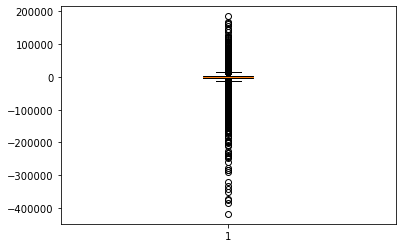

In [261]:
plt.boxplot(pd.Series(diff).dropna())
plt.show()
# cannot use as the difference is too big.

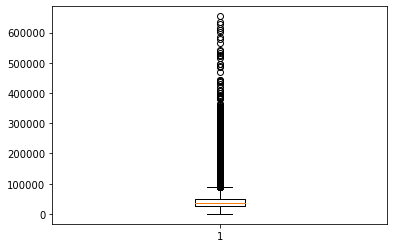

In [262]:
plt.boxplot(init['dereg_value'].dropna())
plt.show()

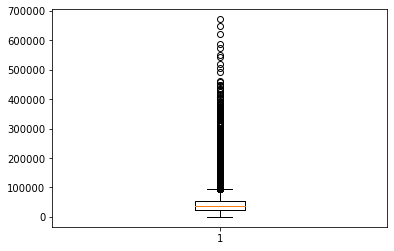

In [263]:
plt.boxplot(df['dereg_value'].dropna())
plt.show()

In [112]:
pd.DataFrame(diff).describe()

,0
count,48560.000000
mean,7415.261523
std,24869.328343
min,-417891.250000
25%,-0.200000
50%,2079.625000
75%,9999.400000
max,445704.800000


In [219]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(actual, pred)
print(mse)

424702989.54028696


In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16784 entries, 0 to 16783
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         16784 non-null  int64  
 1   listing_id         16784 non-null  int64  
 2   title              16784 non-null  object 
 3   make               16784 non-null  object 
 4   model              16784 non-null  object 
 5   description        16439 non-null  object 
 6   manufactured       16590 non-null  float64
 7   original_reg_date  318 non-null    object 
 8   reg_date           16583 non-null  object 
 9   type_of_vehicle    16784 non-null  object 
 10  category           16784 non-null  object 
 11  transmission       16784 non-null  object 
 12  curb_weight        16205 non-null  float64
 13  power              16784 non-null  float64
 14  fuel_type          3490 non-null   object 
 15  engine_cap         16784 non-null  float64
 16  no_of_owners       166

In [337]:
df.to_csv('calculated_dereg.csv')

In [338]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16784 entries, 0 to 16783
Data columns (total 48 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         16784 non-null  int64  
 1   listing_id         16784 non-null  int64  
 2   title              16784 non-null  object 
 3   make               16784 non-null  object 
 4   model              16784 non-null  object 
 5   description        16439 non-null  object 
 6   manufactured       16590 non-null  float64
 7   original_reg_date  318 non-null    object 
 8   reg_date           16583 non-null  object 
 9   type_of_vehicle    16784 non-null  object 
 10  category           16784 non-null  object 
 11  transmission       16784 non-null  object 
 12  curb_weight        16205 non-null  float64
 13  power              16784 non-null  float64
 14  fuel_type          3490 non-null   object 
 15  engine_cap         16784 non-null  float64
 16  no_of_owners       166

In [315]:
df.to_csv('calculated_dereg_test.csv')